# Neural Style Transfer

In [ ]:
# Courtesy: Dipanjan Sarkar 

In [1]:
import numpy as np
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.
/Users/Shared/Anaconda2/anaconda/envs/virtual_platform/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


In [2]:
def preprocess_image(image_path, height=None, width=None):
    height = 400 if not height else height
    width = width if width else int(width * height / height)
    img = load_img(image_path, target_size=(height, width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

def deprocess_image(x):
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [3]:
from keras import backend as K

# This is the path to the image you want to transform.
TARGET_IMG = 'images/golden_gate.jpg'
# This is the path to the style image.
REFERENCE_STYLE_IMG = 'images/bamboo_forest.jpg'

width, height = load_img(TARGET_IMG).size
img_height = 480
img_width = int(width * img_height / height)


target_image = K.constant(preprocess_image(TARGET_IMG, height=img_height, width=img_width))
style_image = K.constant(preprocess_image(REFERENCE_STYLE_IMG, height=img_height, width=img_width))

# Placeholder for our generated image
generated_image = K.placeholder((1, img_height, img_width, 3))

# Combine the 3 images into a single batch
input_tensor = K.concatenate([target_image,
                              style_image,
                              generated_image], axis=0)

In [4]:
model = vgg16.VGG16(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)

In [5]:
layers = {l.name: l.output for l in model.layers}
layers

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 480, 640, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 480, 640, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 240, 320, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 240, 320, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 240, 320, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 120, 160, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 120, 160, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 120, 160, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 120, 160, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 60, 80, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 60, 80, 512) dtype=float32>,
 'b

In [6]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [7]:
def style_loss(style, combination, height, width):
    
    def build_gram_matrix(x):
        features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
        gram_matrix = K.dot(features, K.transpose(features))
        return gram_matrix

    S = build_gram_matrix(style)
    C = build_gram_matrix(combination)
    channels = 3
    size = height * width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [8]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [9]:
# weights for the weighted average loss function
content_weight = 0.05
total_variation_weight = 1e-4


content_layer = 'block4_conv2'
style_layers = ['block{}_conv2'.format(o) for o in range(1,6)]
style_weights = [0.1, 0.15, 0.2, 0.25, 0.3]

# initialize total loss
loss = K.variable(0.)

# add content loss
layer_features = layers[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)

# add style loss
for layer_name, sw in zip(style_layers, style_weights):
    layer_features = layers[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features, 
                    height=img_height, width=img_width)
    loss += (sl*sw)

# add total variation loss
loss += total_variation_weight * total_variation_loss(generated_image)

In [10]:
# Get the gradients of the generated image wrt the loss
grads = K.gradients(loss, generated_image)[0]

# Function to fetch the values of the current loss and the current gradients
fetch_loss_and_grads = K.function([generated_image], [loss, grads])


class Evaluator(object):

    def __init__(self, height=None, width=None):
        self.loss_value = None
        self.grads_values = None
        self.height = height
        self.width = width

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, self.height, self.width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator(height=img_height, width=img_width)


In [12]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from imageio import imwrite
import time
#'st_res'+
result_prefix = TARGET_IMG.split('.')[0]
iterations = 20

# Run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss.
# This is our initial state: the target image.
# Note that `scipy.optimize.fmin_l_bfgs_b` can only process flat vectors.
x = preprocess_image(TARGET_IMG, height=img_height, width=img_width)
x = x.flatten()

for i in range(iterations):
    print('Start of iteration', (i+1))
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    if (i+1) % 5 == 0 or i == 0:
        # Save current generated image only every 5 iterations
        img = x.copy().reshape((img_height, img_width, 3))
        img = deprocess_image(img)
        fname = result_prefix + '_iter%d.png' %(i+1)
        imwrite(fname, img)
        print('Image saved as', fname)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i+1, end_time - start_time))

Start of iteration 1
Current loss value: 6.63089e+09
Image saved as images/golden_gate_iter1.png
Iteration 1 completed in 367s
Start of iteration 2
Current loss value: 3.45601e+09
Iteration 2 completed in 369s
Start of iteration 3
Current loss value: 2.94119e+09
Iteration 3 completed in 368s
Start of iteration 4
Current loss value: 2.73611e+09
Iteration 4 completed in 368s
Start of iteration 5
Current loss value: 2.63752e+09
Image saved as images/golden_gate_iter5.png
Iteration 5 completed in 368s
Start of iteration 6
Current loss value: 2.56372e+09
Iteration 6 completed in 367s
Start of iteration 7
Current loss value: 2.50953e+09
Iteration 7 completed in 367s
Start of iteration 8
Current loss value: 2.46142e+09
Iteration 8 completed in 367s
Start of iteration 9
Current loss value: 2.42091e+09
Iteration 9 completed in 366s
Start of iteration 10
Current loss value: 2.38246e+09
Image saved as images/golden_gate_iter10.png
Iteration 10 completed in 364s
Start of iteration 11
Current loss 

In [13]:
from skimage import io
from glob import glob
from matplotlib import pyplot as plt

%matplotlib inline

In [14]:
content_image = io.imread('images/golden_gate.jpg')
style_image = io.imread('images/bamboo_forest.jpg')

iter1 = io.imread('images/golden_gate_iter1.png')
iter5 = io.imread('images/golden_gate_iter5.png')
iter10 = io.imread('images/golden_gate_iter10.png')
iter15 = io.imread('images/golden_gate_iter15.png')
iter20 = io.imread('images/golden_gate_iter20.png')

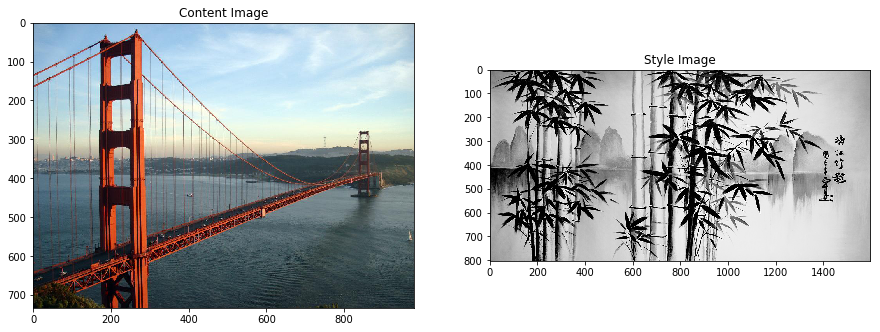

In [15]:
fig = plt.figure(figsize = (15, 6))
ax1 = fig.add_subplot(1,2, 1)
ax1.imshow(content_image)
t1 = ax1.set_title('Content Image')
ax2 = fig.add_subplot(1,2, 2)
ax2.imshow(style_image)
t2 = ax2.set_title('Style Image')

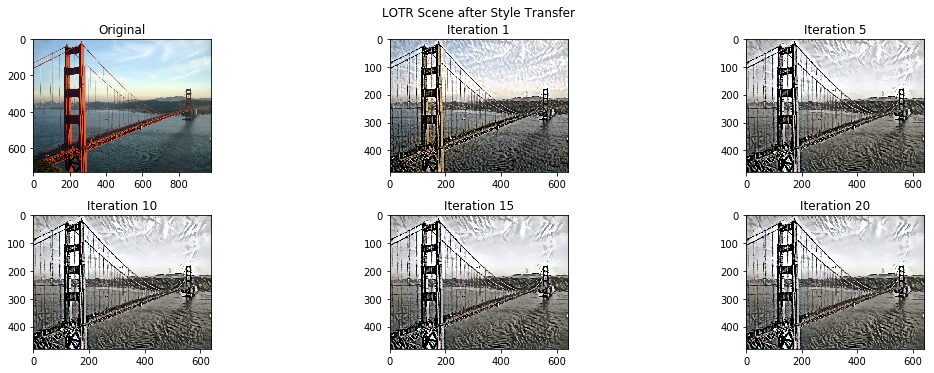

In [16]:
fig = plt.figure(figsize = (15, 15))

ax1 = fig.add_subplot(6,3, 1)
ax1.imshow(content_image)
t1 = ax1.set_title('Original')

ax1 = fig.add_subplot(6,3, 2)
ax1.imshow(iter1)
t1 = ax1.set_title('Iteration 1')

ax1 = fig.add_subplot(6,3, 3)
ax1.imshow(iter5)
t1 = ax1.set_title('Iteration 5')

ax1 = fig.add_subplot(6,3, 4)
ax1.imshow(iter10)
t1 = ax1.set_title('Iteration 10')

ax1 = fig.add_subplot(6,3, 5)
ax1.imshow(iter15)
t1 = ax1.set_title('Iteration 15')

ax1 = fig.add_subplot(6,3, 6)
ax1.imshow(iter20)
t1 = ax1.set_title('Iteration 20')

plt.tight_layout()
fig.subplots_adjust(top=0.95)
t = fig.suptitle('LOTR Scene after Style Transfer')

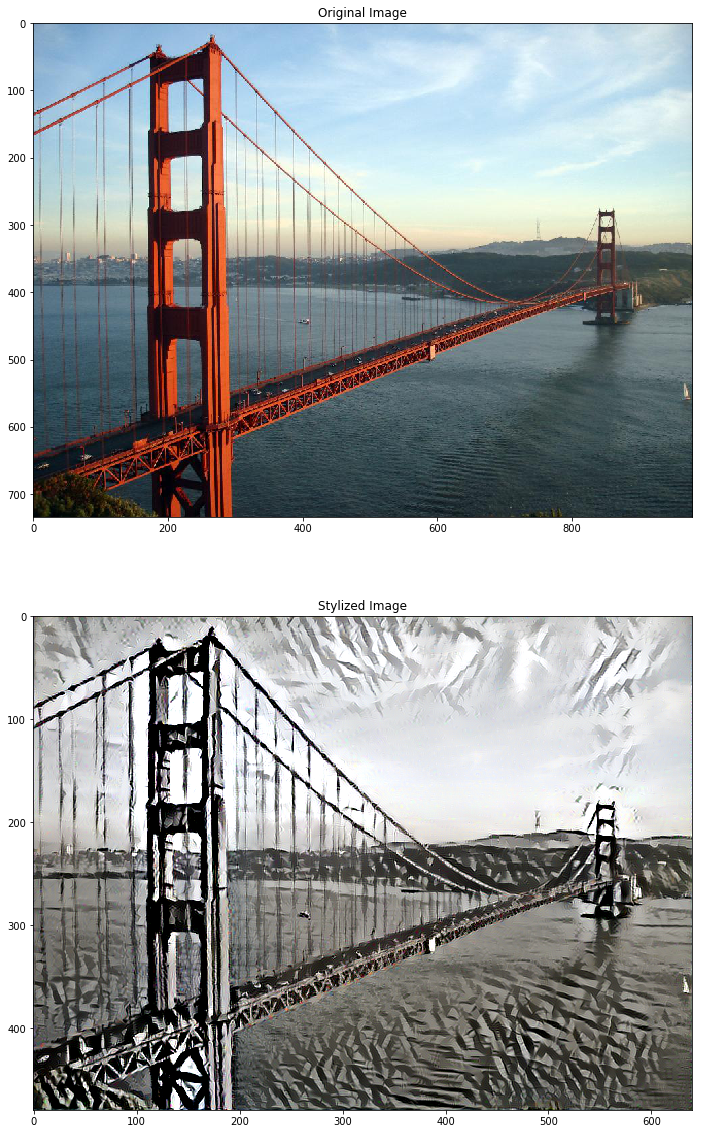

In [17]:
fig = plt.figure(figsize = (20, 20))

ax1 = fig.add_subplot(2,1, 1)
ax1.imshow(content_image)
t1 = ax1.set_title('Original Image')


ax1 = fig.add_subplot(2,1, 2)
ax1.imshow(iter20)
t1 = ax1.set_title('Stylized Image')